# Assignment: Capstone Project - The Battle of Neighborhoods (Week 2)

### Import required libraries

In [156]:
#!conda install -c conda-forge seaborn --yes

In [84]:
#import librairies used for the project
import numpy as np 
import pandas as pd 
import folium
import requests
from bs4 import BeautifulSoup
import os
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
print('All libraries are imported')

All libraries are imported


### Collect and Clean data regarding the house prices and the happiness index in different areas in GB
#### First, the data is collected from here the website of London: https://data.london.gov.uk/dataset?page=1 where we can find a lot of datsets in different areas (civil, culture, tourisme, security....)
#### The data are downloaded as CSV files, cleaned and pre-processed to keep only relevant information that will help the analysis suggested in this project.

In [138]:
res = requests.get("https://www.latlong.net/category/streets-235-17.html")
#res = requests.get("https://www.latlong.net/category/cities-235-15.html")
soup = BeautifulSoup(res.content, "html.parser")
table = soup.find("table")

In [139]:
regions=[]
longs=[]
lats=[]
list_eliminations = [', London, the UK', ', UK', ', London, UK', ', the UK', ', London']
for row in table.findAll("tr"):
    cells = row.findAll("td")
    if len(cells)==3: #Only extract table body not heading
        region = cells[0].find(text=True)
        #for elim in list_eliminations:
        #    region = region.replace(elim,'')
        regions.append(region)
        longs.append(cells[1].find(text=True))
        lats.append(cells[2].find(text=True))
df=pd.DataFrame(regions,columns=["street"])
df["longitude"]=longs
df["latitude"]=lats

convert_dict = {'longitude': float, 
                'latitude': float
               } 
  
df = df.astype(convert_dict)
#df.tocsv('uk_data.csv')
print(df.shape)
print(df.head())

(15, 3)
                                        street  longitude  latitude
0                Harley Street, London, the UK  51.520599 -0.147700
1                   Savile Row, London, the UK  51.511284 -0.140709
2  Antrim Coast Road, Northern Ireland, the UK  54.681999 -5.880000
3           Camden High Street, London, the UK  51.536388 -0.140556
4             Hyde Park Corner, London, the UK  51.502777 -0.151250


In [140]:
address = 'London, UK'
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of UK are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of UK are 51.5073219, -0.1276474.


In [141]:
# create map of UK using latitude and longitude values
map_uk = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, region in zip(df['longitude'], df['latitude'], df['street']):
    label = region
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_uk)  
    
map_uk

### Specify the crendentials for Foursquare API

In [142]:
CLIENT_ID = '4GEA3GGCIKPQB05J5V5TZNP3PZR3NEM4MX555QBHJS5NYVNW' # your Foursquare ID
CLIENT_SECRET = '3I3WAX3N0M4XFIIUG5J1RWVIPPMCN4GZ4A4PWQGLMGW3TKDL' # your Foursquare Secret
VERSION = '20200310' # Foursquare API version

# defining radius and limit of venues to get
radius=500
LIMIT=100

### Get the venues of the streets in the dataset

In [143]:
streets = df['street'].tolist()
latitudes = df['latitude'].tolist()
longitudes = df['longitude'].tolist()
venues_list = []

for name, lat, lng in zip(streets, latitudes, longitudes):
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lng, 
        lat, 
        radius, 
        LIMIT)
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    if results:
        venues_list.append([( 
            name,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['street', 
                      'latitude', 
                      'longitude', 
                      'venue', 
                      'venue latitude', 
                      'venue longitude', 
                      'venue category']
    else:
        print('No Results')
#nearby_venues.to_csv('gb_venues.csv')

### Display the list of venues from the streets we have

In [144]:
nearby_venues

,street,latitude,longitude,venue,venue latitude,venue longitude,venue category
0,"Harley Street, London, the UK",-0.147700,51.520599,Royal Institute of British Architects,51.521108,-0.145014,Art Gallery
1,"Harley Street, London, the UK",-0.147700,51.520599,Daunt Books,51.520433,-0.151824,Bookstore
2,"Harley Street, London, the UK",-0.147700,51.520599,Pierre Marcolini Chocolatier,51.520653,-0.151909,Dessert Shop
3,"Harley Street, London, the UK",-0.147700,51.520599,La Fromagerie,51.519858,-0.152238,Cheese Shop
4,"Harley Street, London, the UK",-0.147700,51.520599,Jardin Du Jasmin,51.521534,-0.143434,Café
...,...,...,...,...,...,...,...
661,"Oxford Street, London, UK",-0.141099,51.515419,Waitrose & Partners JL Foodhall,51.515093,-0.145093,Supermarket
662,"Oxford Street, London, UK",-0.141099,51.515419,Disrepute,51.512121,-0.138179,Cocktail Bar
663,"Oxford Street, London, UK",-0.141099,51.515419,Beast,51.515356,-0.146896,Steakhouse
664,"Oxford Street, London, UK",-0.141099,51.515419,Fresh Healthy Eating Cafe,51.513228,-0.136394,Juice Bar


#### Then, the venues found by Foursquare API are analyzed such as the number of unique venues and unique venues' categories. We present some charts of the venues' distribution.

Number of unique categories is: 151
Number of unique venues is: 531


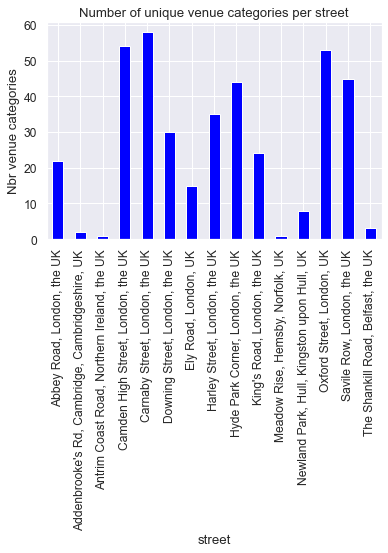

In [145]:
print('Number of unique categories is:', len(nearby_venues['venue category'].unique()))
print('Number of unique venues is:', len(nearby_venues['venue'].unique()))
categories = nearby_venues.groupby("street")["venue category"].apply(lambda x: len(list(np.unique(x))))
categories.plot.bar(color="blue")
plt.title('Number of unique venue categories per street')
plt.xlabel('street')
plt.ylabel('Nbr venue categories')
plt.show()

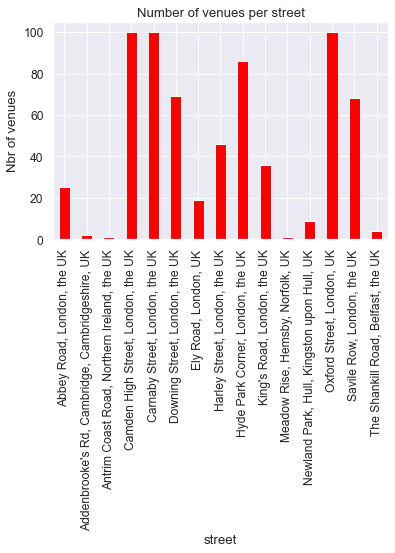

In [146]:
categories = nearby_venues.groupby("street")["venue"].count()
categories.plot.bar(color="red")
plt.title('Number of venues per street')
plt.xlabel('street')
plt.ylabel('Nbr of venues')
plt.show()

#### The maximum number of unique categories per venue is 58 and the minimum is 1.


### Get the unique categories for the streets in the dataset.
#### The top-5 categories are: Hotel, Coffee Shop, Clothing Store, Pub and French Restaurant.

In [147]:
df_str_cat = nearby_venues.groupby("venue category")["street"].count().to_frame()
df_str_cat.columns = ["nb_streets"]
df_str_cat = df_str_cat.reset_index()
df_str_cat.sort_values(by='nb_streets', ascending=False)

,venue category,nb_streets
68,Hotel,33
24,Coffee Shop,30
111,Pub,27
22,Clothing Store,26
50,French Restaurant,17
...,...,...
117,River,1
118,Road,1
73,Indie Theater,1
120,Roof Deck,1


### Create the new dataframe and display the top 3 venues for each neighborhood

In [148]:
# Analyze each of the streets from the results
# one hot encoding
london_onehot = pd.get_dummies(nearby_venues[['venue category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['street'] = nearby_venues['street'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

london_onehot.head()

,street,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,Bar,...,Theater,Toy / Game Store,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Watch Shop,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,"Harley Street, London, the UK",0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Harley Street, London, the UK",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Harley Street, London, the UK",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Harley Street, London, the UK",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Harley Street, London, the UK",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [149]:
london_grouped = london_onehot.groupby('street').mean().reset_index()
london_grouped

,street,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,Bar,...,Theater,Toy / Game Store,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Watch Shop,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,"Abbey Road, London, the UK",0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.04,0.040000,0.000000,...,0.000000,0.00,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.04
1,"Addenbrooke's Rd, Cambridge, Cambridgeshire, UK",0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
2,"Antrim Coast Road, Northern Ireland, the UK",0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
3,"Camden High Street, London, the UK",0.000000,0.01,0.000000,0.000000,0.000000,0.000000,0.00,0.010000,0.030000,...,0.000000,0.00,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
4,"Carnaby Street, London, the UK",0.000000,0.00,0.040000,0.010000,0.010000,0.000000,0.00,0.010000,0.000000,...,0.010000,0.00,0.000000,0.010000,0.000000,0.010000,0.000000,0.000000,0.030000,0.00
5,"Downing Street, London, the UK",0.000000,0.00,0.028986,0.000000,0.000000,0.000000,0.00,0.014493,0.014493,...,0.028986,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
6,"Ely Road, London, UK",0.000000,0.00,0.000000,0.000000,0.000000,0.052632,0.00,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
7,"Harley Street, London, the UK",0.000000,0.00,0.021739,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.00,0.021739,0.000000,0.021739,0.000000,0.043478,0.000000,0.000000,0.00
8,"Hyde Park Corner, London, the UK",0.011628,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.011628,...,0.000000,0.00,0.011628,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
9,"King's Road, London, the UK",0.027778,0.00,0.027778,0.000000,0.000000,0.000000,0.00,0.111111,0.000000,...,0.000000,0.00,0.000000,0.000000,0.027778,0.000000,0.000000,0.000000,0.027778,0.00


In [150]:
# method to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [151]:
# get the top venues per street
london_grouped = london_onehot.groupby('street').mean().reset_index()
num_top_venues = 3
indicators = ['st', 'nd', 'rd']

columns = ['street']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
london_venues_sorted = pd.DataFrame(columns=columns)
london_venues_sorted['street'] = london_grouped['street']

for ind in np.arange(london_grouped.shape[0]):
    london_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

london_venues_sorted.head(20)

,street,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,"Abbey Road, London, the UK",Cricket Ground,Coffee Shop,Yoga Studio
1,"Addenbrooke's Rd, Cambridge, Cambridgeshire, UK",Campground,Playground,Yoga Studio
2,"Antrim Coast Road, Northern Ireland, the UK",Beach,Yoga Studio,Furniture / Home Store
3,"Camden High Street, London, the UK",Coffee Shop,Pub,Pizza Place
4,"Carnaby Street, London, the UK",Clothing Store,Boutique,Art Gallery
5,"Downing Street, London, the UK",Pub,Hotel,Monument / Landmark
6,"Ely Road, London, UK",Pub,Convenience Store,Coffee Shop
7,"Harley Street, London, the UK",Hotel,French Restaurant,Indian Restaurant
8,"Hyde Park Corner, London, the UK",Hotel,Lounge,Pub
9,"King's Road, London, the UK",Bakery,Pub,English Restaurant


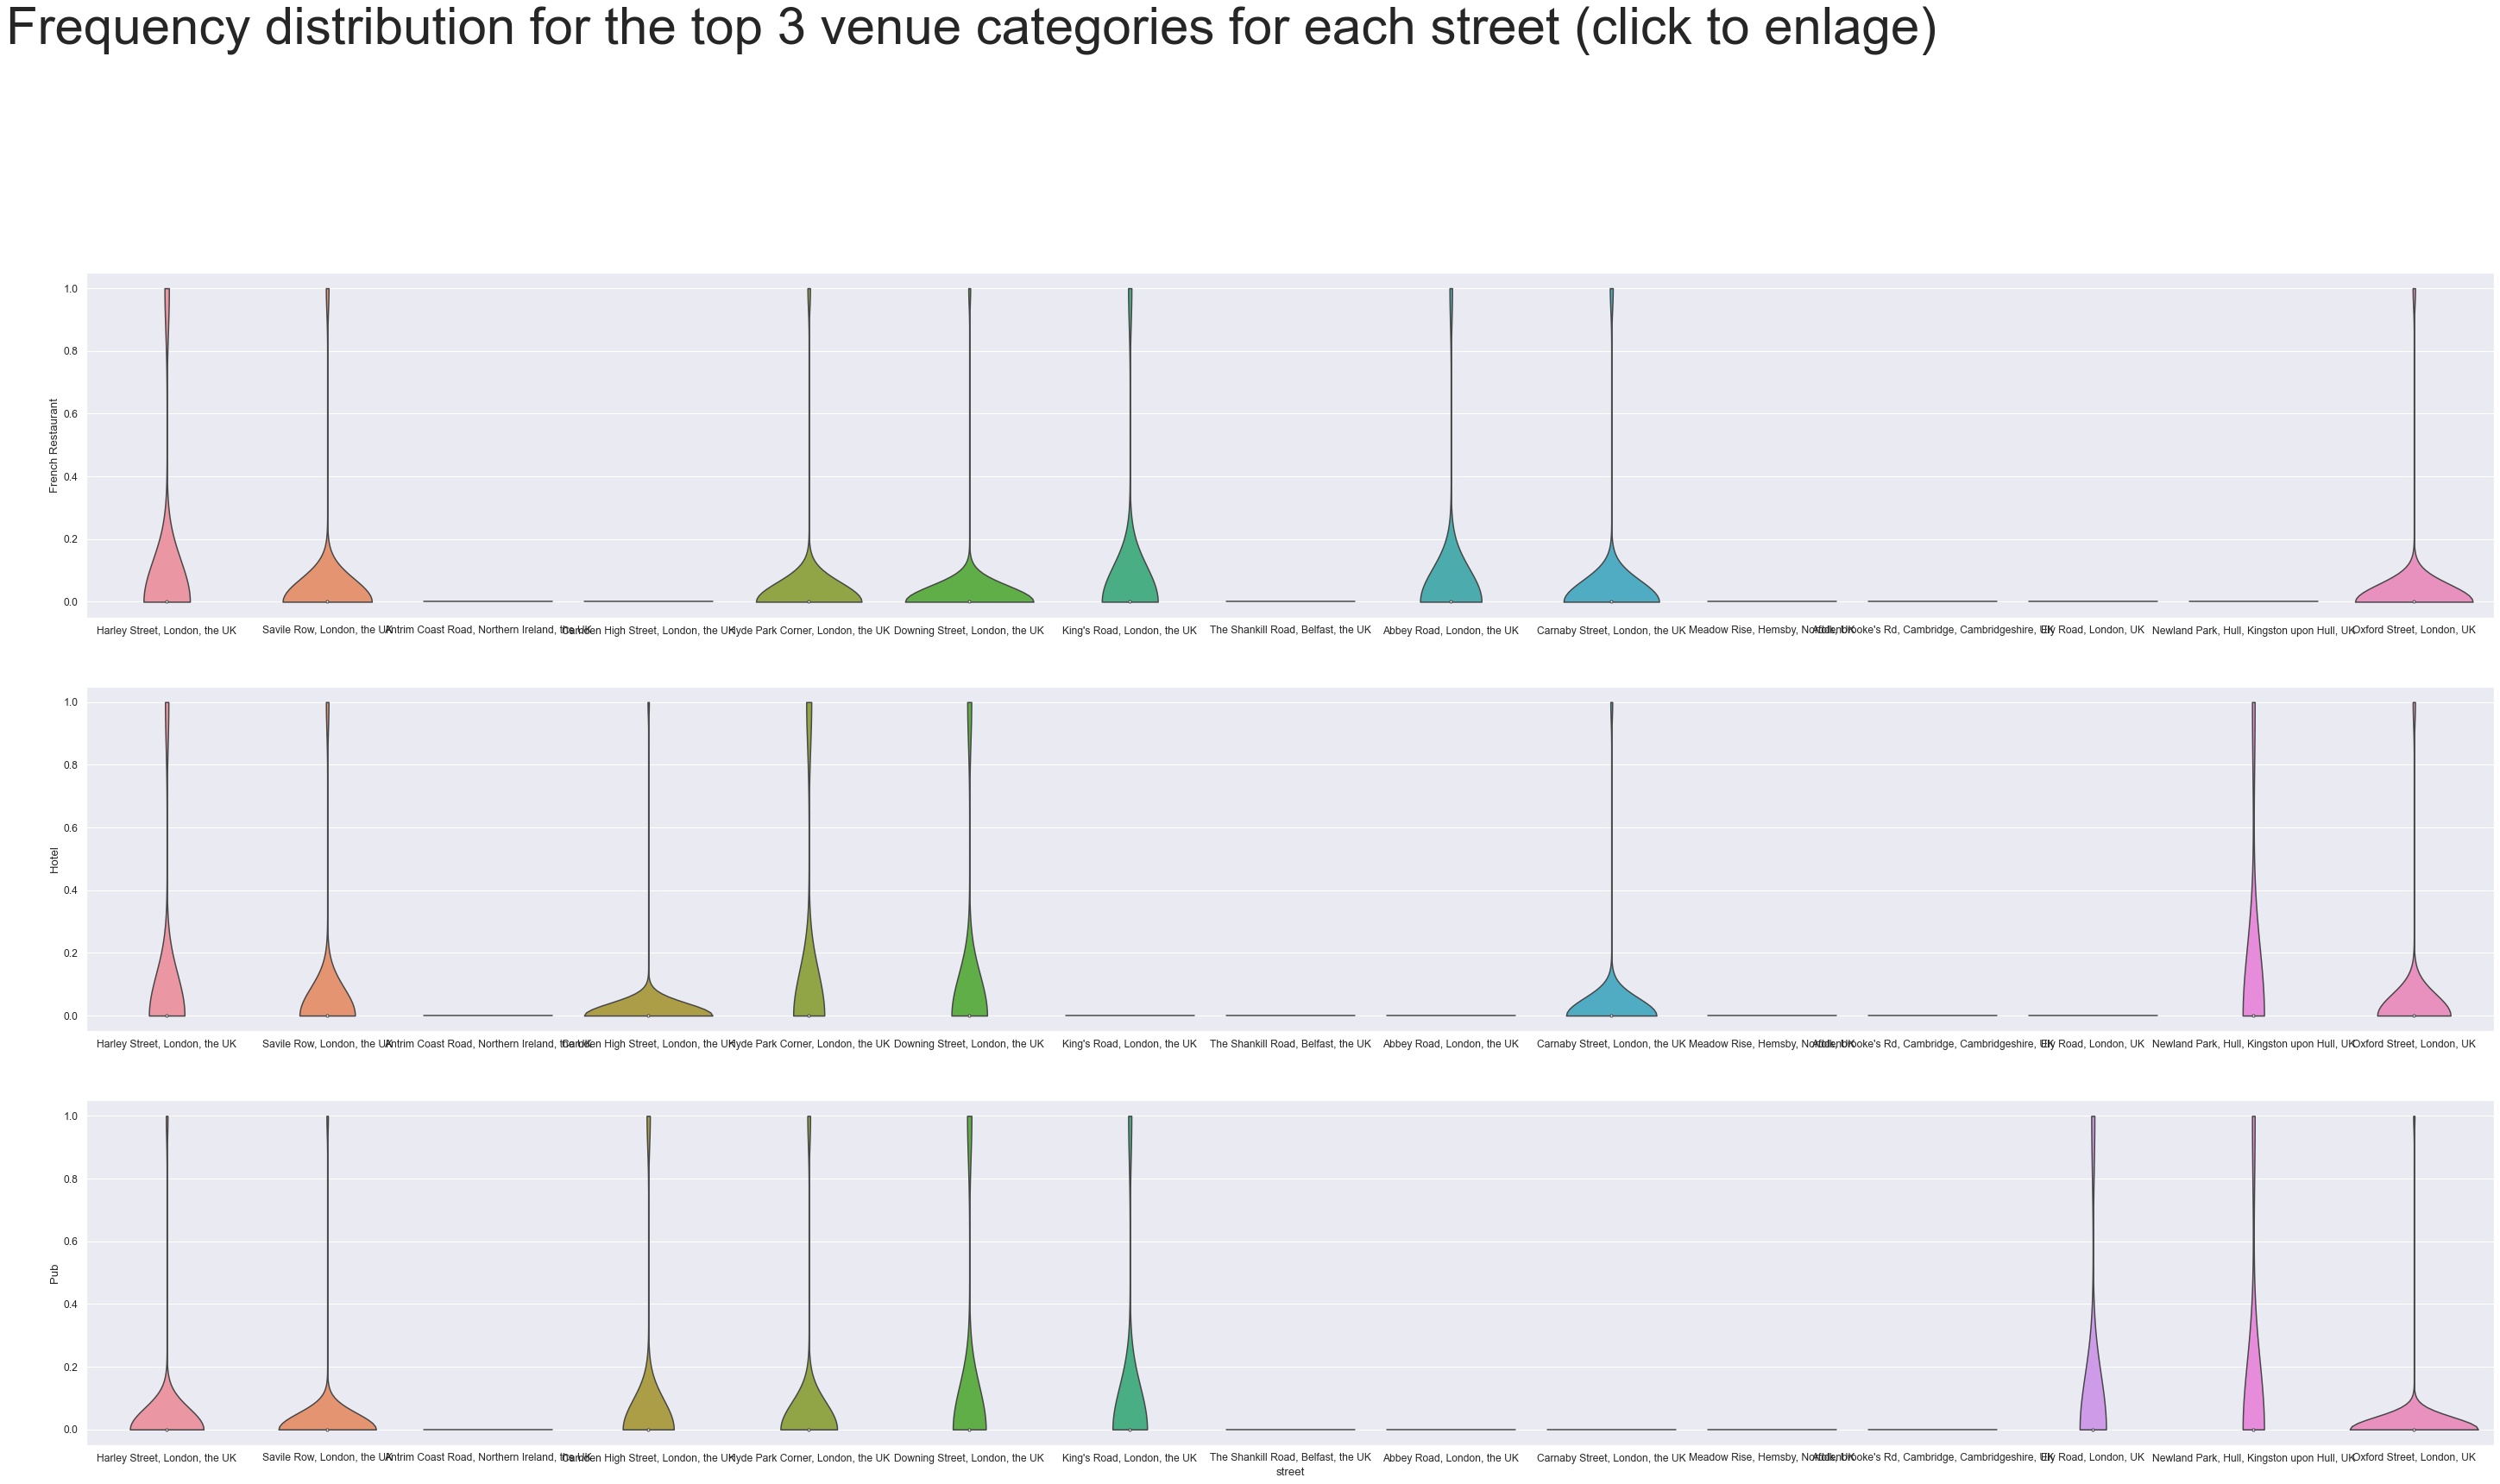

In [152]:
# Explore a plot of the data 

import seaborn as sns

fig = plt.figure(figsize=(50,25))
sns.set(font_scale=1.1)

ax = plt.subplot(3,1,1)
sns.violinplot(x="street", y="French Restaurant", data=london_onehot, cut=0);
plt.xlabel("")

ax = plt.subplot(3,1,2)
sns.violinplot(x="street", y="Hotel", data=london_onehot, cut=0);
plt.xlabel("")

plt.subplot(3,1,3)
sns.violinplot(x="street", y="Pub", data=london_onehot, cut=0);

ax.text(-1.0, 3.1, 'Frequency distribution for the top 3 venue categories for each street (click to enlage)', fontsize=60)
plt.savefig ("Distribution_Frequency_Venues_3_categories.png", dpi=240)
plt.show()



#### To answer the business question, we notice that there are always different types of restaurants concentrated in the streets  where there are hotels or pubs.

### Explore the category "Backery"
#### Check the frequency of Backery in each street to get an overview as the data mlay give some insights on the location.

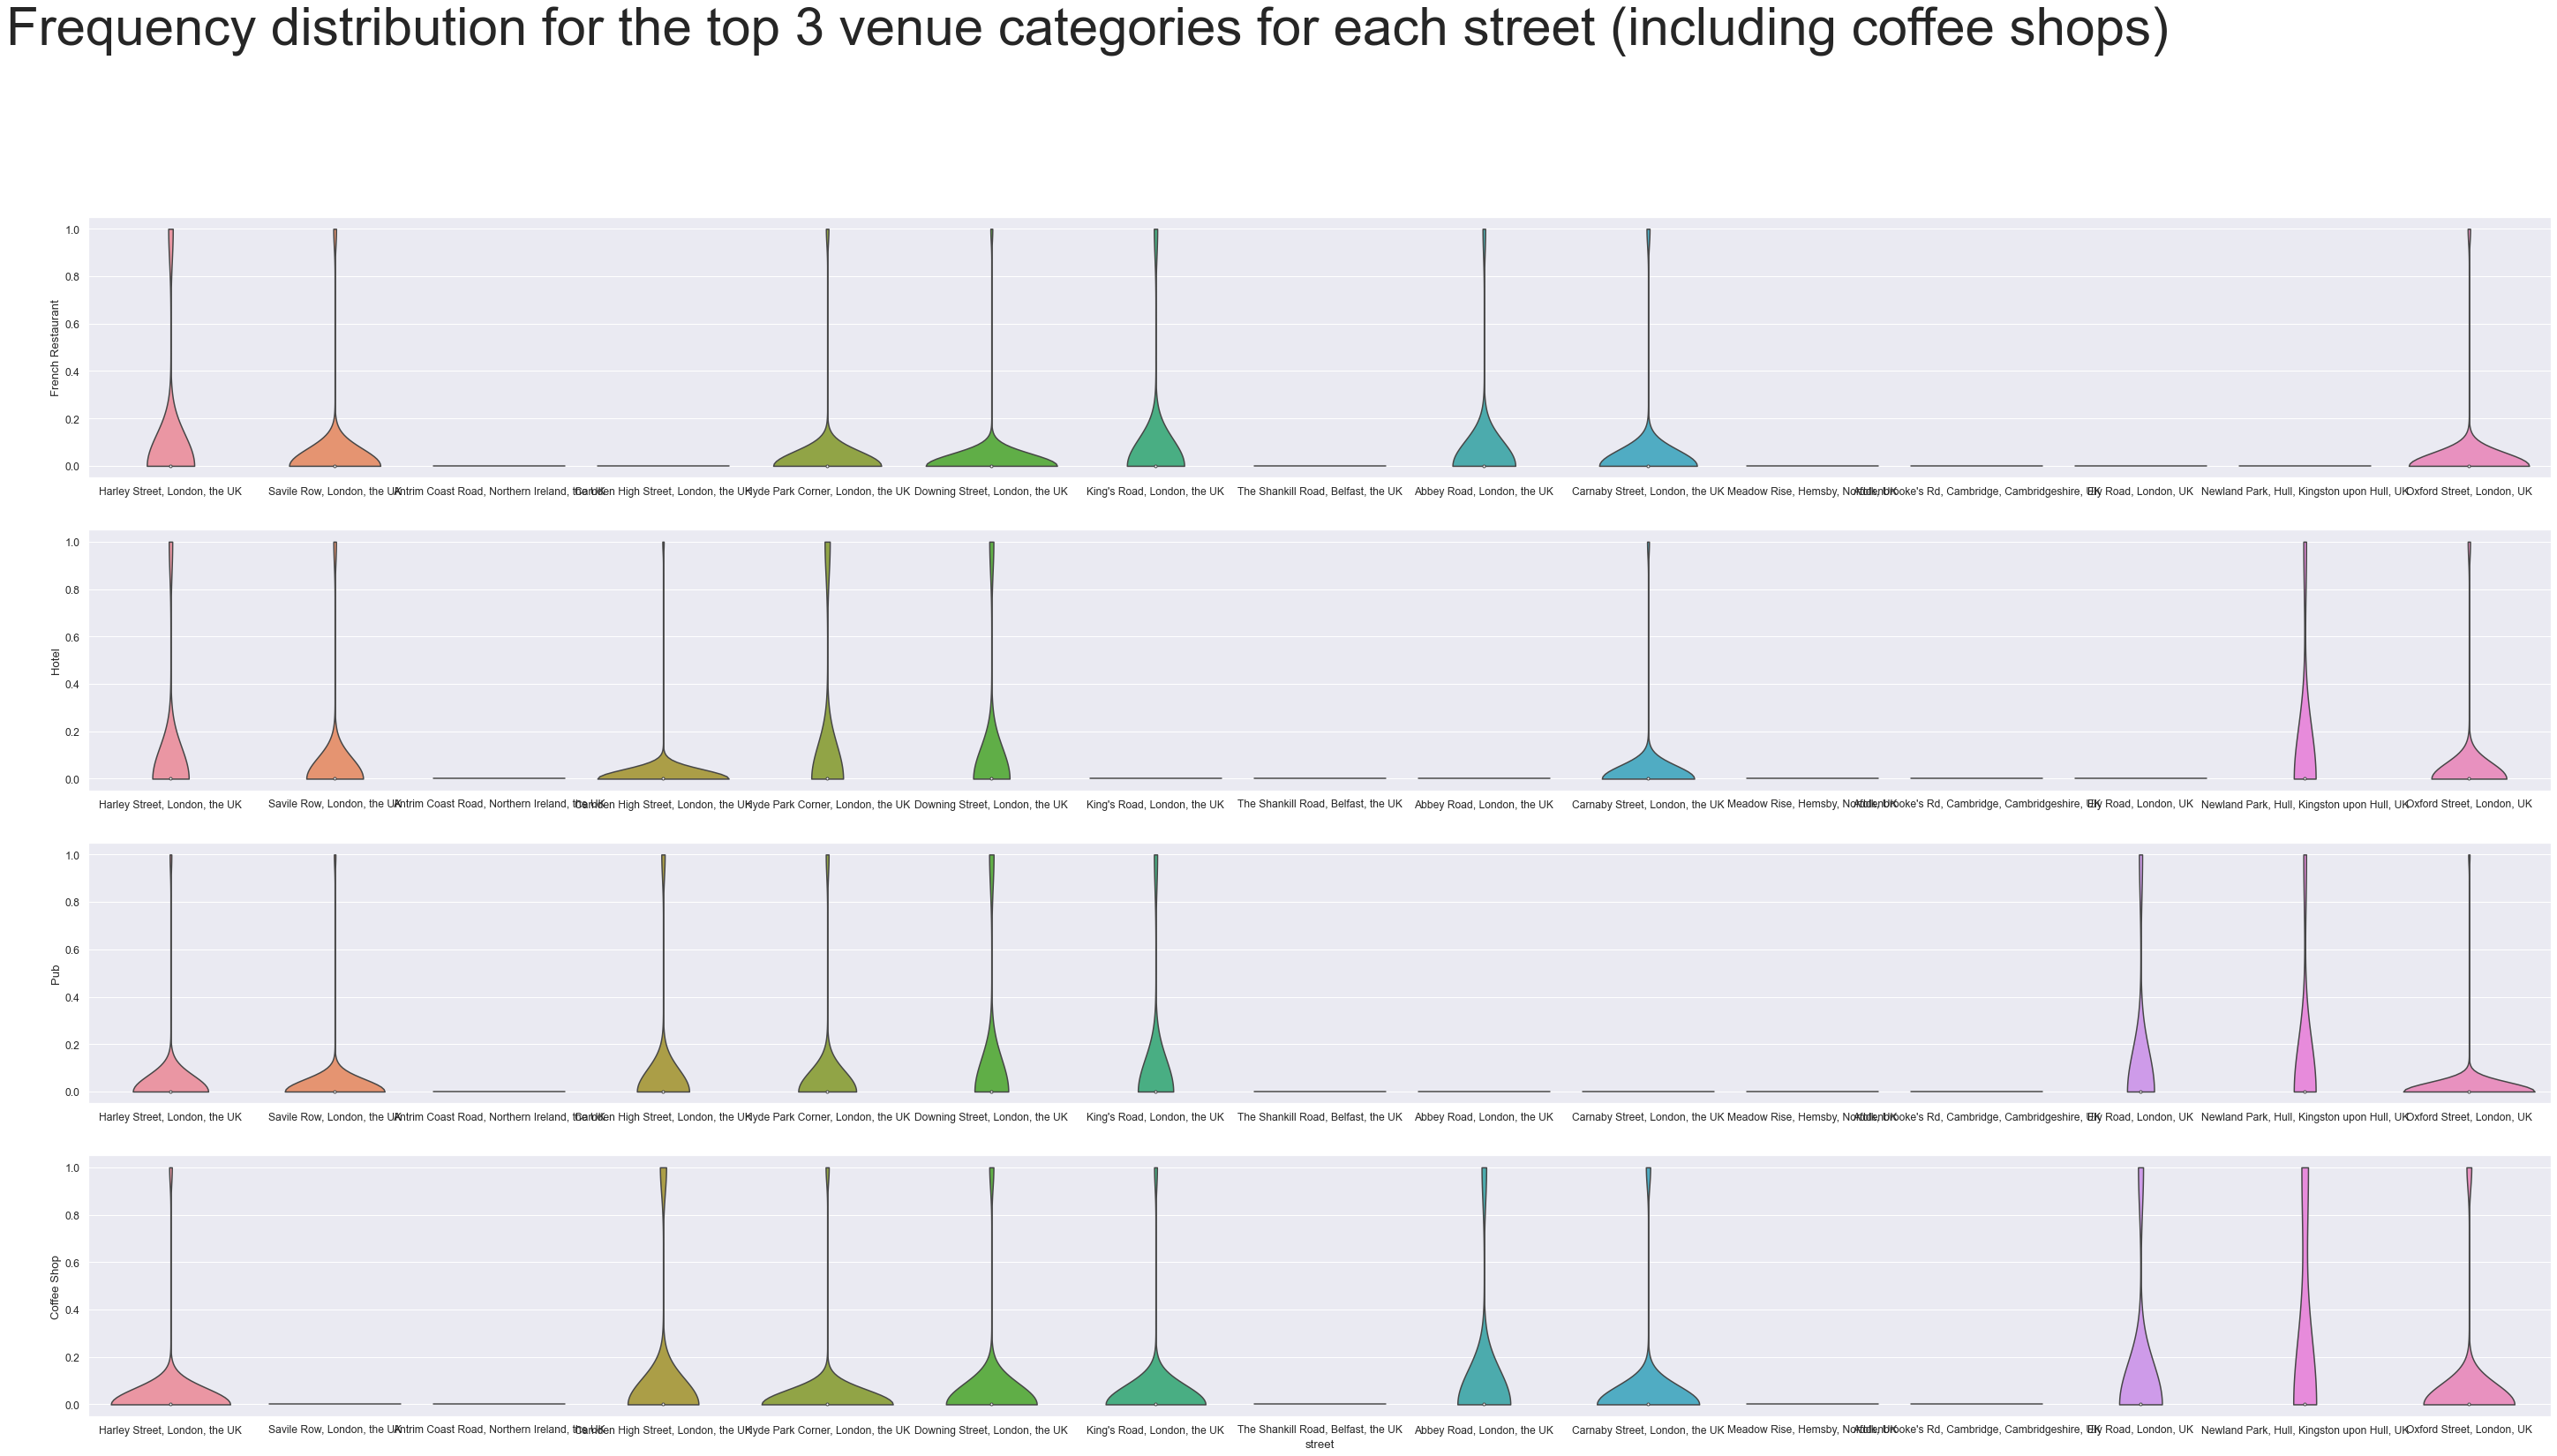

In [153]:
import seaborn as sns

fig = plt.figure(figsize=(50,25))
sns.set(font_scale=1.1)

ax = plt.subplot(4,1,1)
sns.violinplot(x="street", y="French Restaurant", data=london_onehot, cut=0);
plt.xlabel("")

ax = plt.subplot(4,1,2)
sns.violinplot(x="street", y="Hotel", data=london_onehot, cut=0);
plt.xlabel("")

plt.subplot(4,1,3)
sns.violinplot(x="street", y="Pub", data=london_onehot, cut=0);
plt.xlabel("")

plt.subplot(4,1,4)
sns.violinplot(x="street", y="Coffee Shop", data=london_onehot, cut=0);


ax.text(-1.0, 3.1, 'Frequency distribution for the top 3 venue categories for each street (including coffee shops)', fontsize=60)
plt.savefig ("Distribution_Frequency_Venues_3_categories_coffee.png", dpi=240)
plt.show()


#### From the displayed data, we chose 3 streets based on the criteria the clients gave. Thus, the final selection contains the following 3 streets:
- Harley Street
- Hyde Park Corner
- Oxford street

### Get the selected streets and visualize them on a map

In [154]:
selected_streets = df[df["street"].isin(['Hyde Park Corner, London, the UK',
                                         'Harley Street, London, the UK',
                                         'Oxford Street, London, UK'])]
selected_streets

,street,longitude,latitude
0,"Harley Street, London, the UK",51.520599,-0.147700
4,"Hyde Park Corner, London, the UK",51.502777,-0.151250
14,"Oxford Street, London, UK",51.515419,-0.141099


In [155]:
# Create a map of London with the 3 selected streets
map_selected_streets = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, label in zip(selected_streets['latitude'], selected_streets['longitude'],
                           selected_streets['street']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lng, lat],
        radius=45,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.2,
        parse_html=False).add_to(map_selected_streets)  
    
map_selected_streets
